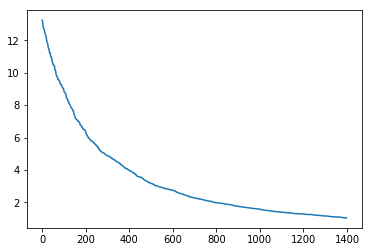

In [151]:
import numpy as np
import matplotlib.pyplot as plt
plt.tight_layout()

class site:
    def __init__(self, position, properties):
        self.index = position
        for name,value in properties.items():
            setattr(self, name, value)
        

class Ising:
    def __init__(self, inL, inh0):
        self.L = inL
        self.h0 = inh0
        self.rstep = 0
        self.system = []
        self.Omegalist = []
        self.hlist = [[0]]
        self.jlist = [[0]]
        self.lslist = [[0]]
        self.lblist = [[0]]
        self.mlist = [[0]]
        for i in range(1,self.L):
            self.system.append(site(i, {'Jright':np.random.uniform(0,1), 'h':np.random.uniform(0,self.h0), 'ls':.5, 'lb':.5, 'm':.5}))
        self.system.append(site(self.L-1, {'Jright':0, 'h':np.random.uniform(0,self.h0), 'ls':.5, 'lb':.5, 'm':.5}))
        
        self.hlist[0][0] = self.system[0].h
        self.jlist[0][0] = self.system[0].Jright
        self.lslist[0][0] = self.system[0].ls
        self.lblist[0][0] = self.system[0].lb
        self.mlist[0][0] = self.system[0].m
        for i in range(1,self.L-1):
            self.hlist[0].append(self.system[i].h)
            self.jlist[0].append(self.system[i].Jright)
            self.lslist[0].append(self.system[i].ls)
            self.lblist[0].append(self.system[i].lb)
            self.mlist[0].append(self.system[i].m)
        self.hlist[0].append(self.system[self.L-1].h)
        self.lslist[0].append(self.system[self.L-1].ls)
        self.mlist[0].append(self.system[self.L-1].m)
    
    
    def renormStep(self):
        bond = None
        Omega = 0
        OmegaPos = None
        
        #finding max energy scale
        for i in range(self.L):
            if Omega<self.system[i].Jright:
                Omega = self.system[i].Jright
                OmegaPos = i
                bond = True
            if Omega<self.system[i].h:
                Omega = self.system[i].h
                OmegaPos = i
                bond = False
        self.Omegalist.append(Omega)
        
        #decimating
        if bond:
            self.system[OmegaPos].h = self.system[OmegaPos+1].h * self.system[OmegaPos].h / Omega #hright*hleft/Omega
            self.system[OmegaPos].ls = self.system[OmegaPos].ls + self.system[OmegaPos+1].ls + self.system[OmegaPos].lb
            self.system[OmegaPos].lb = self.system[OmegaPos+1].lb
            self.system[OmegaPos].m = self.system[OmegaPos].m + self.system[OmegaPos+1].m
            self.system[OmegaPos].Jright = self.system[OmegaPos+1].Jright
            del self.system[OmegaPos+1]
        elif OmegaPos<(self.L-1) and OmegaPos != 0:
            self.system[OmegaPos-1].Jright = self.system[OmegaPos-1].Jright*self.system[OmegaPos].Jright/Omega #jleft*jright/Omega
            self.system[OmegaPos-1].lb = self.system[OmegaPos-1].lb + self.system[OmegaPos].ls + self.system[OmegaPos].lb
            del self.system[OmegaPos]
        elif OmegaPos == 0:
            del self.system[OmegaPos]
        else:
            self.system[OmegaPos-1].Jright = 0
            del self.system[OmegaPos]
        
        #book keeping
        self.L -= 1
        self.rstep += 1
        
        #adding new distribution info
        self.hlist.append([0])
        self.hlist[self.rstep][0] = self.system[0].h
        self.jlist.append([0])
        self.jlist[self.rstep][0] = self.system[0].Jright
        self.lslist.append([0])
        self.lslist[self.rstep][0] = self.system[0].ls
        self.lblist.append([0])
        self.lblist[self.rstep][0] = self.system[0].lb
        self.mlist.append([0])
        self.mlist[self.rstep][0] = self.system[0].m
        for i in range(1,self.L-1):
            self.hlist[self.rstep].append(self.system[i].h)
            self.jlist[self.rstep].append(self.system[i].Jright)
            self.lslist[self.rstep].append(self.system[i].ls)
            self.lblist[self.rstep].append(self.system[i].lb)
            self.mlist[self.rstep].append(self.system[i].m)
        self.hlist[self.rstep].append(self.system[self.L-1].h)
        self.lslist[self.rstep].append(self.system[self.L-1].ls)
        self.mlist[self.rstep].append(self.system[self.L-1].m)
        
    #Analytic Output
    def printCouplings(self):
        for i in range(self.L-1):
              print('h' + str(i) + ' = ' + str(self.system[i].h) + '\nJ' + str(i) + ',' + str(i+1) + ' = ' + str(self.system[i].Jright))
        print('h' + str(self.L-1) + ' = ' + str(self.system[self.L-1].h))
        print()
    
    def printTracked(self, step = None):
        if step == None:
            step = self.rstep
        hlistlog = np.log(self.hlist[step])
        jlistlog = np.log(self.jlist[step])
        print('log average h is: ' + str(np.mean(hlistlog)))
        print('log h variance is: ' + str(np.var(hlistlog)) + '\n')
        print('log average J is: ' + str(np.mean(jlistlog)))
        print('log J variance is: ' + str(np.var(jlistlog)) + '\n')
        print('average spin cluster size is: ' + str(np.mean(self.lslist[step])) + '\n')
        print('average bond length is: ' + str(np.mean(self.lblist[step])) + '\n')
        print('average magnetic moment is: ' + str(np.mean(self.mlist[step]))+ '\n')
        print('energy scale is: ' + str(self.Omegalist[step])+ '\n')
    
    def deltaTest(self, verbose = False, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        delta = []
        for i in range(startStep, stopStep+1):
            if verbose:
                print('delta at level ' + str(i) + ' would be: ' + str((np.mean(np.log(self.hlist[i])) - np.mean(np.log(self.jlist[i])))/(np.var(np.log(self.hlist[i])) + np.var(np.log(self.jlist[i])))) + '\n')
            delta.append((np.mean(np.log(self.hlist[i])) - np.mean(np.log(self.jlist[i])))/(np.var(np.log(self.hlist[i])) + np.var(np.log(self.jlist[i]))))
        print('delta, over levels ' + str(startStep) + '-' + str(stopStep) + ', has variance: ' + str(np.var(delta)) + '\n')
    
    def typicalLengthTest(self, verbose = False, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        tlengthb = 0
        lv = 2/(np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0])))
        crossRenorm = 0
        for i in range(startStep, stopStep+1):
            tlengthb = np.exp(np.mean(np.log(self.lblist[i])))
            tlengthh = np.exp(np.mean(np.log(self.lslist[i])))
            if verbose:
                print('Typical bond length at level ' + str(i) + ' is: ' + str(tlengthb) + '\n')
                print('Typical cluster size at level ' + str(i) + ' is: ' + str(tlengthh) + '\n')
            if not crossRenorm:
                if tlengthb > lv:
                    crossRenorm = i
        print('The crossover where renorm has freed itself from initial conditions is: ' + str(crossRenorm) + '\n')
    
    def energyLengthScaling(self, startStep = 0, stopStep = None):
        #seems to not actually be correct
        if stopStep == None:
            stopStep = self.rstep
        VI = np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0]))
        for i in range(startStep, stopStep+1):
            print('log averaged h scales at renorm level ' + str(i) + ' with coefficient: ' + str(-np.mean(np.log(self.hlist[i]))/np.sqrt(VI * np.exp(np.mean(np.log(self.lslist[i]))))) + '\n')
            print('log averaged J scales at renorm level ' + str(i) + ' with coefficient: ' + str(-np.mean(np.log(self.jlist[i]))/np.sqrt(VI * np.exp(np.mean(np.log(self.lblist[i]))))) + '\n')
    
    def typicalEnergyLengthGraph(self, startStep = 0, stopStep = None):
        printlist = []
        lv = 2/(np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0])))
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep):
            printlist.append(((np.exp(np.mean(np.log(self.lblist[i-1]/lv))))**.5)/(np.log(self.Omegalist[0]/self.Omegalist[i])))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def momentPerLtest(self, startStep = 0, stopStep = None):
        #not working either, maybe I'm messing something up
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep, stopStep+1):
            print('Magnetization scaling coefficient: ' + str(np.average(np.divide(self.mlist[i],self.lslist[i]))/(np.absolute((np.mean(np.log(self.hlist[0])) - np.mean(np.log(self.jlist[0])))/(np.var(np.log(self.hlist[0])) + np.var(np.log(self.jlist[0]))))**(3/2-np.sqrt(5)/2))) + '\n')
    
    def typicalMomentTest(self, startStep = 0, stopStep = None):
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep):
            print('Typical magnetic moment scaling coefficient at renorm ' + str(i) + ' is: ' + str(np.exp(np.average(np.log(self.mlist[i])))/((np.log(self.Omegalist[0]/self.Omegalist[i]))**(3/2-np.sqrt(5)/2))) + '\n')
    
    def typicalMomentGraph(self, startStep = 0, stopStep = None):
        printlist = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep):
            printlist.append(np.exp(np.average(np.log(self.mlist[i-1])))/((np.log(self.Omegalist[0]/self.Omegalist[i]))**(3/2-np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def typical2MomentGraph(self, startStep = 0, stopStep = None):
        #WARNING this is probably the incorrect definition of typical
        printlist = []
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep+1, stopStep):
            printlist.append(np.average(np.log(self.mlist[i-1]))/((np.log(self.Omegalist[0]/self.Omegalist[i]))**(3/2-np.sqrt(5)/2)))
        out, sub = plt.subplots(1)
        sub.plot(printlist)
    
    def distGraph(self, startStep = 0, stopStep = None, delta = 1, h = True, J = True, lb = False, ls = False, m = False):
        if stopStep == None:
            stopStep = self.rstep
        for i in range(startStep, stopStep, delta):
            if h:
                outh, subh = plt.subplots(1)
                subh.hist(np.log(self.hlist[i]),30)
            if J:
                outj, subj = plt.subplots(1)
                subj.hist(np.log(self.jlist[i]),30)
            if lb:
                outlb, sublb = plt.subplots(1)
                sublb.hist(self.lblist[i],10)
            if ls:
                outls, subls = plt.subplots(1)
                subls.hist(self.lslist[i],10)
            if m:
                outm, subm = plt.subplots(1)
                subm.hist(self.mlist[i],20)
        
            
            
        
        
        
    
L0 = 2000
tester = Ising(L0,1)

#tester.printCouplings()
#tester.printDistributions()
for i in range(L0-100):
    tester.renormStep()
#tester.printCouplings()
#tester.printTracked()
#tester.energyLengthScaling()
#tester.deltaTest(True)
#tester.momentPerLtest()
#tester.distGraph(startStep = 1000, delta = 100,h = False, J = False, m = True)
#tester.typicalMomentGraph(startStep = 1000, stopStep = 1600)
#tester.typicalLengthTest()
tester.typicalEnergyLengthGraph(startStep = 200, stopStep = 1600)
